# Flood prediction Model

Import Libraries

In [1]:
#Import some basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time

Load Dataset And PreProcessing

In [2]:
#Read the data present in dataset
data = pd.read_csv('kerala.csv')
#Using data.head() we can see the top 5 rows of the dataset
data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL RAINFALL,FLOODS
0,KERALA,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,3248.6,YES
1,KERALA,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,3326.6,YES
2,KERALA,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,3271.2,YES
3,KERALA,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,3129.7,YES
4,KERALA,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,2741.6,NO


In [3]:
#Now we will cheak if any colomns is left empty
data.apply(lambda x:sum(x.isnull()), axis=0)

SUBDIVISION         0
YEAR                0
JAN                 0
FEB                 0
MAR                 0
APR                 0
MAY                 0
JUN                 0
JUL                 0
AUG                 0
SEP                 0
OCT                 0
NOV                 0
DEC                 0
 ANNUAL RAINFALL    0
FLOODS              0
dtype: int64

In [4]:
#We want the data in numbers, therefore we will replace the yes/no in floods coloumn by 1/0
data['FLOODS'].replace(['YES','NO'],[1,0],inplace=True)

In [5]:
#Let's see how are data looks like now
data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL RAINFALL,FLOODS
0,KERALA,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,3248.6,1
1,KERALA,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,3326.6,1
2,KERALA,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,3271.2,1
3,KERALA,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,3129.7,1
4,KERALA,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,2741.6,0


In [6]:
#Now let's seperate the data which we are gonna use for prediction
x = data.iloc[:,1:14]
x.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4
1,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5
2,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0
3,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3
4,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2


In [7]:
#Now seperate the flood label from the dataset
y = data.iloc[:, -1]
y.head()

0    1
1    1
2    1
3    1
4    0
Name: FLOODS, dtype: int64

EDA

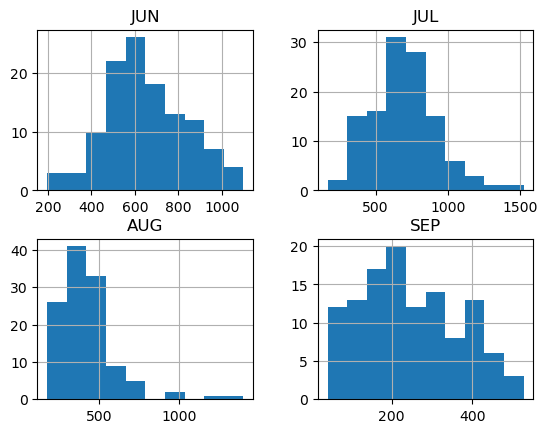

In [8]:
#Let's see hoe the rainfall index vary during rainy season
import matplotlib.pyplot as plt
%matplotlib inline
c = data[['JUN','JUL','AUG','SEP']]
c.hist()
plt.show()

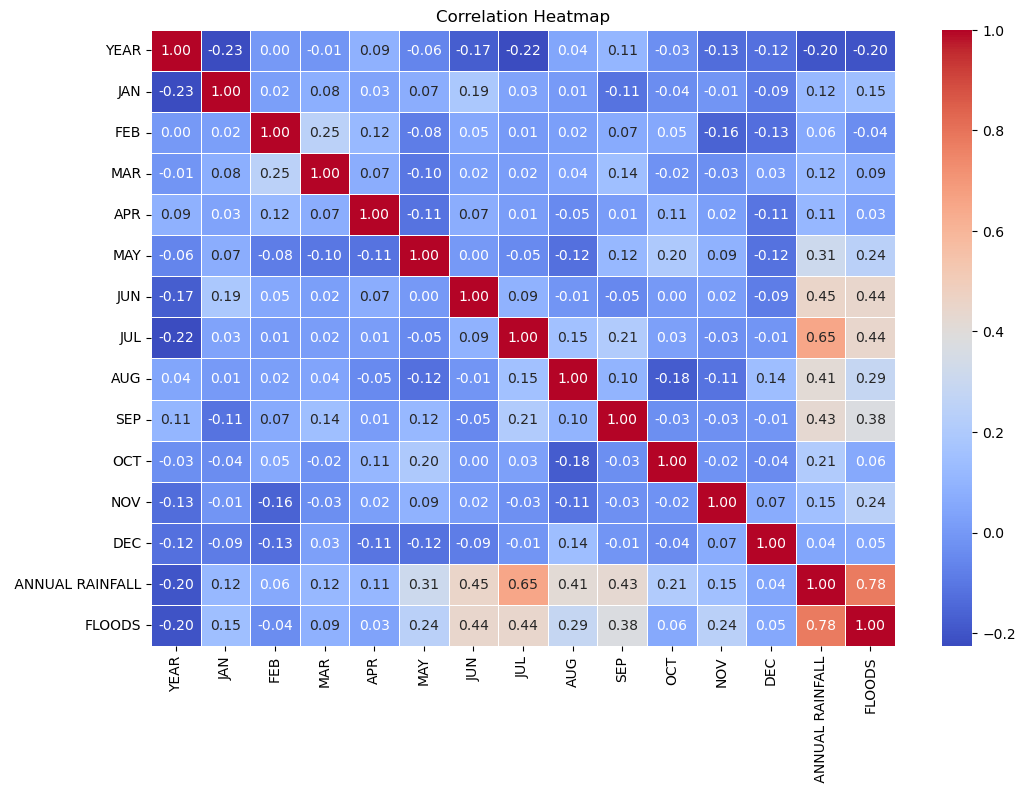

In [9]:
plt.figure(figsize=(12, 8))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

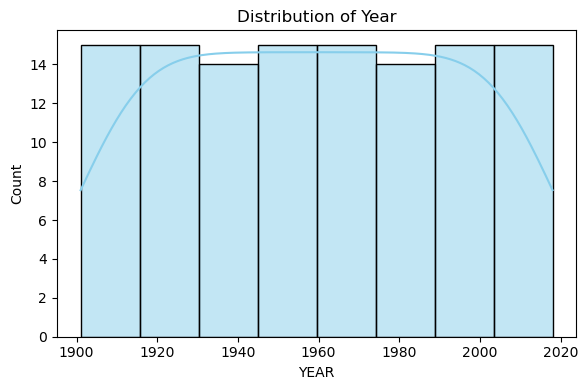

In [10]:
plt.figure(figsize=(6, 4))
sns.histplot(data['YEAR'], kde=True, color='skyblue')
plt.title(f'Distribution of Year')
plt.xlabel("YEAR")
plt.tight_layout()
plt.show()

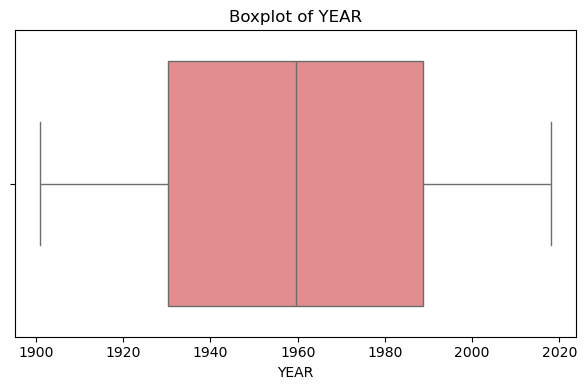

In [11]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=data['YEAR'], color='lightcoral')
plt.title(f'Boxplot of YEAR')
plt.tight_layout()
plt.show()

Scaling

In [12]:
#Data might be widely distributed so let's scale it between 0 and 1
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler(feature_range=(0,1))
minmax.fit(x).transform(x)

array([[0.        , 0.34371257, 0.56582278, ..., 0.39727673, 0.95570189,
        0.2388724 ],
       [0.00854701, 0.08023952, 0.03291139, ..., 0.5804966 , 0.37952709,
        0.60039565],
       [0.01709402, 0.03832335, 0.23544304, ..., 0.57188626, 0.37563604,
        0.29129575],
       ...,
       [0.98290598, 0.02874251, 0.04810127, ..., 0.31517821, 0.28105358,
        0.11622156],
       [0.99145299, 0.02275449, 0.08607595, ..., 0.24809772, 0.18258007,
        0.18793274],
       [1.        , 0.34850299, 0.65949367, ..., 0.57589107, 0.28105358,
        0.3214639 ]])

Train Test Split

In [13]:
#Let's divide the dataset into 2 sets:train and test in ratio (4:1)
from sklearn import model_selection,neighbors
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

# Prediction Algorithms:

# 1. Logistic Regression

In [14]:
x_train_std = minmax.fit_transform(x_train)
x_test_std = minmax.transform(x_test)

In [36]:
# Logistic Regression with time measurement
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score


start_time_lr = time.time()

lr = LogisticRegression()
lr_clf = lr.fit(x_train_std,y_train)

lr_accuracy = cross_val_score(lr_clf,x_test_std,y_test,cv=3,scoring='accuracy')

y_pred_lr = lr_clf.predict(x_test_std)

end_time_lr = time.time()
print("\naccuracy score: %f"%(accuracy_score(y_test,y_pred_lr)*100))
print("recall score: %f"%(recall_score(y_test,y_pred_lr)*100))
print("roc score: %f"%(roc_auc_score(y_test,y_pred_lr)*100))
print("[LR] Time taken: %.2f seconds" % (end_time_lr - start_time_lr))



accuracy score: 100.000000
recall score: 100.000000
roc score: 100.000000
[LR] Time taken: 0.03 seconds


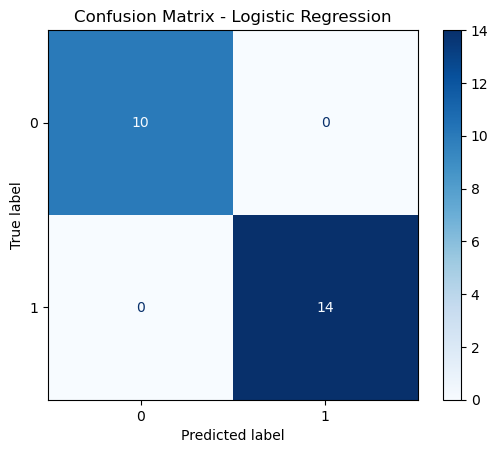

In [37]:
# Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# 2. Random Forest Classification

In [29]:
# Random Forest (non-parallel) with time measurement
start_time_rf = time.time()

rmf = RandomForestClassifier(max_depth=3,random_state=0)
rmf_clf = rmf.fit(x_train,y_train)
rmf_clf

rmf_clf_acc = cross_val_score(rmf_clf,x_train_std,y_train,cv=3,scoring="accuracy")

y_pred = rmf_clf.predict(x_test)


end_time_rf = time.time()
print("\naccuracy score:%f"%(accuracy_score(y_test,y_pred)*100))
print("recall score:%f"%(recall_score(y_test,y_pred)*100))
print("roc score:%f"%(roc_auc_score(y_test,y_pred)*100))
print("[RF] Time taken: %.2f seconds" % (end_time_rf - start_time_rf))



accuracy score:91.666667
recall score:85.714286
roc score:92.857143
[RF] Time taken: 0.47 seconds


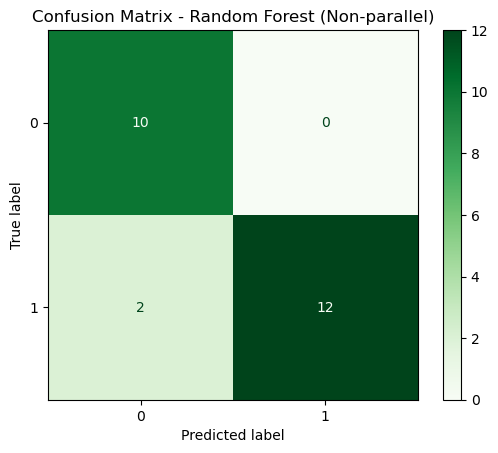

In [18]:
# Confusion Matrix - Random Forest (Non-parallel)
cm_rmf = confusion_matrix(y_test, y_pred)
disp_rmf = ConfusionMatrixDisplay(confusion_matrix=cm_rmf)
disp_rmf.plot(cmap='Greens')
plt.title("Confusion Matrix - Random Forest (Non-parallel)")
plt.show()

# 3. Parallel Random Forest Classification

In [30]:
# Parallel Random Forest with time measurement
start_time_rf_parallel = time.time()

rmf_parallel = RandomForestClassifier(max_depth=3, random_state=0, n_jobs=-1)
rmf_parallel_clf = rmf_parallel.fit(x_train, y_train)
rmf_parallel_clf

# Use cross_val_score with estimator (not fitted model), pass parallel parameter
rmf_parallel_clf_acc = cross_val_score(rmf_parallel, x_train_std, y_train, cv=3, scoring="accuracy", n_jobs=-1)

# Predict
y_pred_parallel = rmf_parallel_clf.predict(x_test)

end_time_rf_parallel = time.time()

# Output scores
print("\n[Parallel RF] Accuracy Score: %f" % (accuracy_score(y_test, y_pred_parallel) * 100))
print("[Parallel RF] Recall Score: %f" % (recall_score(y_test, y_pred_parallel) * 100))
print("[Parallel RF] ROC-AUC Score: %f" % (roc_auc_score(y_test, y_pred_parallel) * 100))
print("[Parallel RF] Time taken: %.2f seconds" % (end_time_rf_parallel - start_time_rf_parallel))



[Parallel RF] Accuracy Score: 91.666667
[Parallel RF] Recall Score: 85.714286
[Parallel RF] ROC-AUC Score: 92.857143
[Parallel RF] Time taken: 0.36 seconds


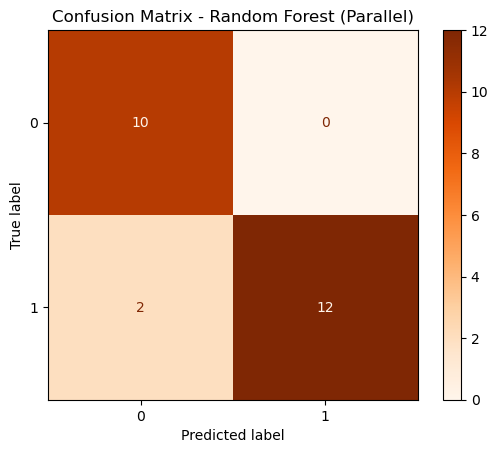

In [31]:
# Confusion Matrix - Random Forest (Parallel)
cm_rmf_parallel = confusion_matrix(y_test, y_pred_parallel)
disp_rmf_parallel = ConfusionMatrixDisplay(confusion_matrix=cm_rmf_parallel)
disp_rmf_parallel.plot(cmap='Oranges')
plt.title("Confusion Matrix - Random Forest (Parallel)")
plt.show()

Model Comparison

In [38]:
# Ensure predictions exist
y_pred_lr = lr_clf.predict(x_test)
y_pred = rmf_clf.predict(x_test)
y_pred_parallel = rmf_parallel_clf.predict(x_test)

Metric Comparison between models

In [42]:
accuracy_scores = [
    accuracy_score(y_test, y_pred_lr) * 100,
    accuracy_score(y_test, y_pred) * 100,
    accuracy_score(y_test, y_pred_parallel) * 100
]

recall_scores = [
    recall_score(y_test, y_pred_lr) * 100,
    recall_score(y_test, y_pred) * 100,
    recall_score(y_test, y_pred_parallel) * 100
]

roc_scores = [
    roc_auc_score(y_test, y_pred_lr) * 100,
    roc_auc_score(y_test, y_pred) * 100,
    roc_auc_score(y_test, y_pred_parallel) * 100
]

models = ['Logistic Regression', 'RF (Non-parallel)', 'RF (Parallel)']

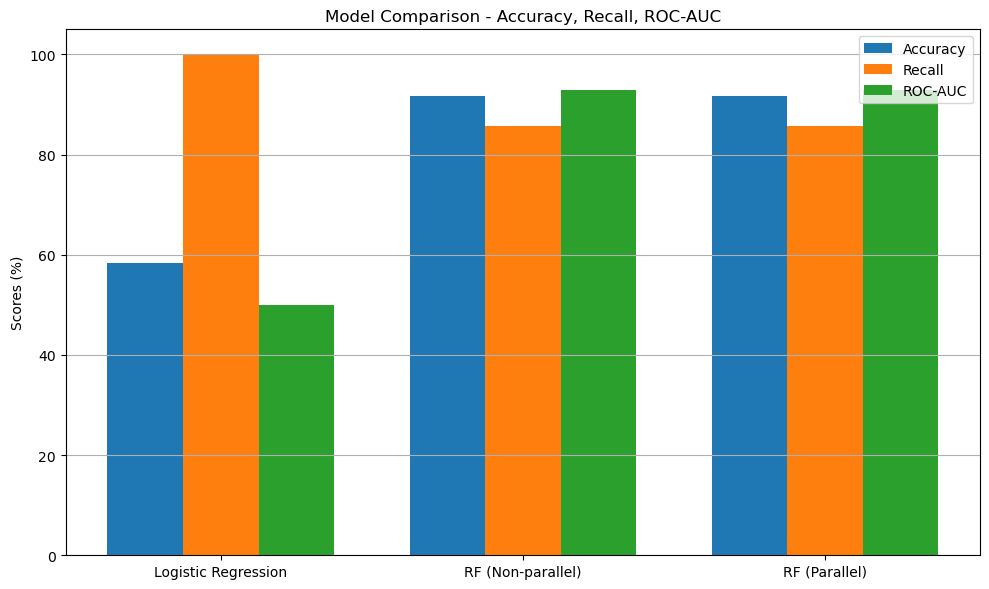

In [43]:
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, accuracy_scores, width, label='Accuracy')
ax.bar(x, recall_scores, width, label='Recall')
ax.bar(x + width, roc_scores, width, label='ROC-AUC')

ax.set_ylabel('Scores (%)')
ax.set_title('Model Comparison - Accuracy, Recall, ROC-AUC')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Training Time Comparison

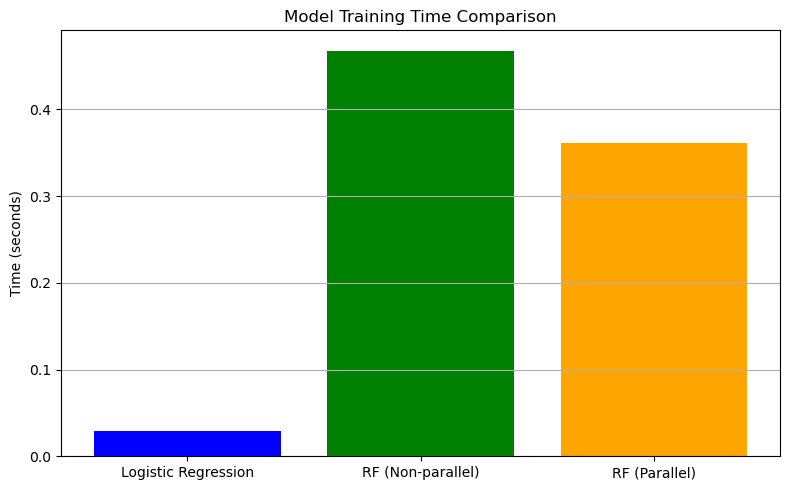

In [44]:
training_times = [
    end_time_lr - start_time_lr,
    end_time_rf - start_time_rf,
    end_time_rf_parallel - start_time_rf_parallel
]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models, training_times, color=['blue', 'green', 'orange'])
ax.set_ylabel('Time (seconds)')
ax.set_title('Model Training Time Comparison')
plt.grid(axis='y')
plt.tight_layout()
plt.show()